## Вариант 1: ВЫДЕЛЕНИЕ ГРАНИЦ

### Алгоритм выделения границ Кэнни

#### Импорт библиотек

In [317]:
%pylab inline
import matplotlib.pyplot as plt 
import numpy
import matplotlib.image as mpimg
import os
import scipy.misc as sm
import skimage
import cv2

Populating the interactive namespace from numpy and matplotlib


##### Алгоритм Кенни:
1. Перевод изображения в монохромное
2. Удаление шума путем размытия Гауса
3. Поиск градиентов
4. Подавление не-максимумов
5. Двойная пороговая фильтрация
6. Трассировка области неоднозначности

#### Загрузка изображений

##### Функция вывода изображений на экран

In [318]:
def draw(img: numpy.ndarray, isgray = 0) -> None:
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    if isgray:
        plt.imshow(img, cmap='gray')
        return
    plt.imshow(img)        

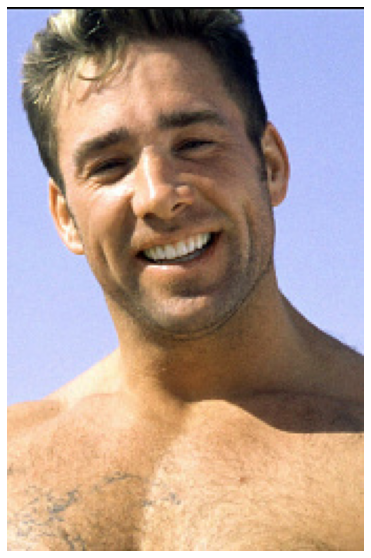

In [319]:
image_fi = cv2.imread("images/billy.jpg")
image_fi = cv2.cvtColor(image_fi, cv2.COLOR_BGR2RGB)
draw(image_fi)

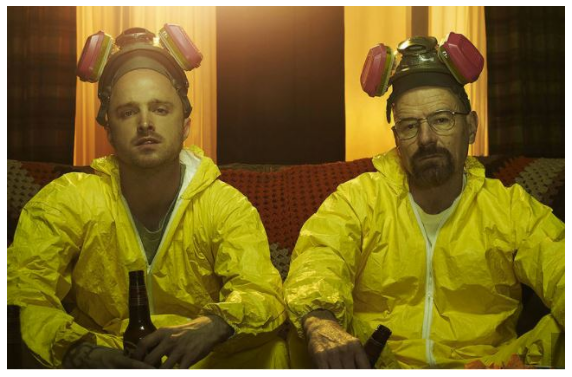

In [320]:
image_se = cv2.imread("images/bb.jpg")
image_se = cv2.cvtColor(image_se, cv2.COLOR_BGR2RGB)
draw(image_se)

#### Конвертация в монохромное

1. monochrome - конвертирует изображение в монохромное.

2. transform - приводит изображения к размерности (высота, ширина, 3 одинаковых компоненты цвета)

In [321]:
def monochrome(source_image: numpy.ndarray) -> numpy.ndarray:
    height, width, _ = source_image.shape
    new_image = numpy.zeros((height, width))
    for i in range(height):
        for j in range(width):
            new_image[i][j] = source_image[i][j][0] * 0.21 + source_image[i][j][1] * 0.72 + source_image[i][j][2] * 0.07   
    return new_image

def transform(source_image: numpy.ndarray) -> numpy.ndarray:
    height, width = source_image.shape
    new_image = numpy.zeros((height, width, 3))
    for i in range(height):
        for j in range(width):
            new_image[i][j][0] = source_image[i][j]
            new_image[i][j][1] = source_image[i][j]
            new_image[i][j][2] = source_image[i][j]
    return new_image

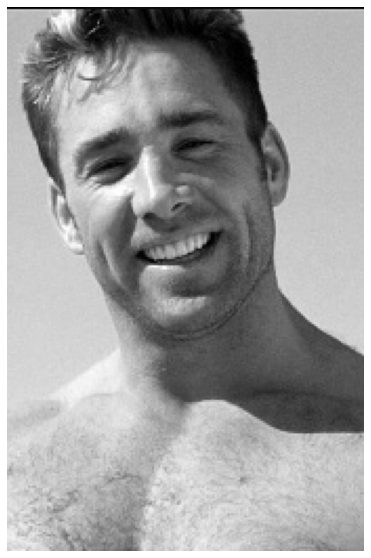

In [322]:
image_fi_new = monochrome(image_fi)
image_fi_new = transform(image_fi_new)
draw(image_fi_new.astype('uint8'))

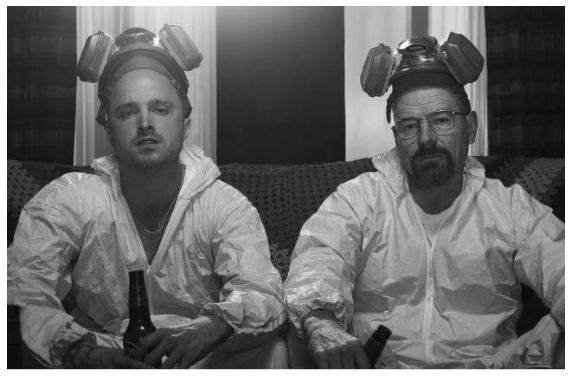

In [323]:
image_se_new = monochrome(image_se)
image_se_new = transform(image_se_new)
draw(image_se_new.astype('uint8'))

#### Размытие методом Гаусса

Для подавления шума, воспользуемся размытием изображения фильтром Гаусса

In [324]:
import math


def create_gaussian_kernel(radius: int, sigma: int) -> numpy.ndarray:
    norm = 0
    size = 2 * radius + 1
    kernel = np.zeros(shape=(size, size), dtype='float32')
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            kernel[i + radius, j + radius] = (math.exp((-1) * (i * i + j * j) / (sigma * sigma)))
            norm += kernel[i + radius, j + radius]
    for i in range(size):
        for j in range(size):
            kernel[i, j] = kernel[i, j] / norm
    return kernel


def calculate_new_color(img: numpy.ndarray, x: int, y: int, radius: int, kernel: numpy.ndarray) -> [int, int, int]:
    height, width, _ = img.shape
    r = 0
    g = 0
    b = 0
    for i in range(-radius, radius + 1):
        for j in range(-radius, radius + 1):
            idx = max(min(x + i, width - 1), 0)
            idy = max(min(y + j, height - 1), 0)
            color = img[idy, idx]
            b += color[0] * kernel[i, j]
            g += color[1] * kernel[i, j]
            r += color[2] * kernel[i, j]
    b = int(max(min(b, 255), 0))
    g = int(max(min(g, 255), 0))
    r = int(max(min(r, 255), 0))
    return [b, g, r]


def gauss_filter(img: numpy.ndarray) -> numpy.ndarray:
    height, width, _ = img.shape
    result = np.zeros(shape=(height, width, 3), dtype='uint8')
    radius = 1
    kernel = create_gaussian_kernel(radius, 2)
    for x in range(width):
        for y in range(height):
            result[y, x] = calculate_new_color(img, x, y, radius, kernel)
    return result

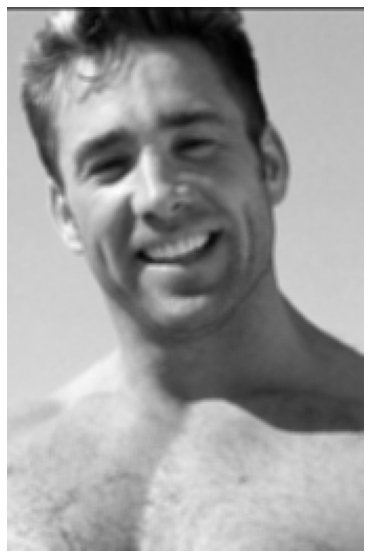

In [325]:
image_fi = gauss_filter(image_fi_new)
draw(image_fi)

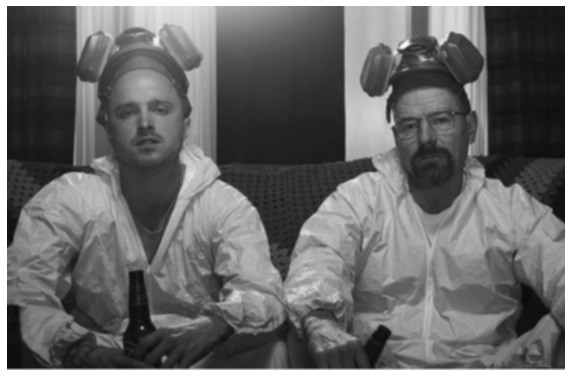

In [326]:
image_se = gauss_filter(image_se_new)
draw(image_se)

#### Поиск градиентов

Оператор Собеля часто применяют в алгоритмах выделения границ. Это дискретный дифференциальный оператор, вычисляющий приближенное значение градиента яркости изображения. Результатом применения оператора Собеля в каждой точке изображения является либо вектор градиента яркости в этой точке, либо его норма

In [327]:
def sobel_filter(img: numpy.ndarray) -> (numpy.ndarray, numpy.ndarray):
    size = img.shape
    new_image = np.zeros((size[0], size[1], ))
    MGy = np.zeros((size[0], size[1], ))
    MGx = np.zeros((size[0], size[1], ))
    tetha = np.zeros((size[0], size[1], ))
    for i in range(1, size[0] - 1):
        for j in range(1, size[1] - 1):
            #  Сначала складываем положительные, чтобы текущая сумма не стала меньше 0 и не произошло переполнение
            MGy[i][j] = img[i - 1][j - 1][0] + 2*img[i-1][j][0] + img[i - 1][j + 1][0] - img[i + 1][j - 1][0] - 2*img[i + 1][j][0] - img[i + 1][j + 1][0]
            MGx[i][j] =  2*img[i][j - 1][0] + img[i + 1][j - 1][0] + img[i - 1][j - 1][0] - img[i - 1][j + 1][0] - 2*img[i][j + 1][0] - img[i + 1][j + 1][0]
            new_image[i][j] = min(255, math.sqrt(MGy[i] [j] ** 2 + MGx[i][j] ** 2))
    tetha = numpy.arctan2(MGy, MGx)
    return new_image, tetha

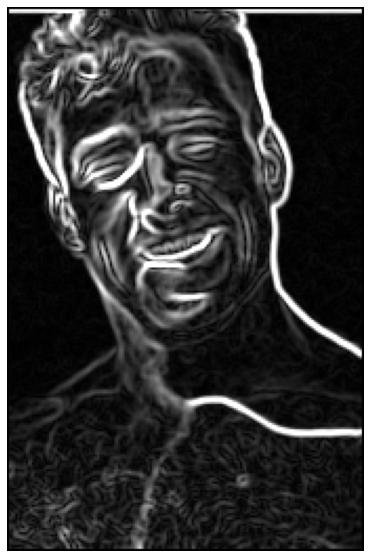

In [328]:
image_fi_new, theta_fi = sobel_filter(image_fi)
draw(image_fi_new, 1)

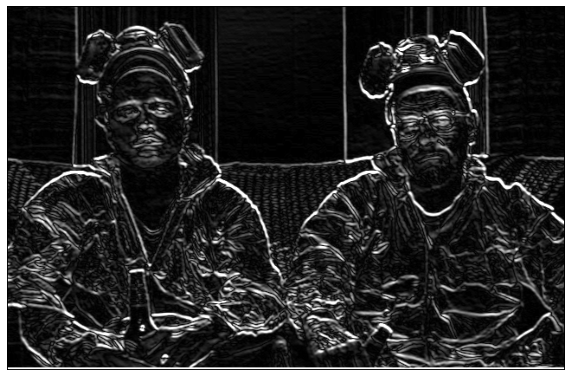

In [329]:
image_se_new, theta_se = get_grad(image_se)
draw(image_se_new, 1)

#### Подавление не-максимумов

 Для каждого пикселя ищется два соседа (в положительном и отрицательном направлениях градиента, предполагая, что каждый сосед занимает угол pi / 4,  а 0 - направление прямо вправо). Если величина текущего пикселя больше, чем величины соседей, ничего не меняется, в противном случае величина текущего пикселя устанавливается на ноль.

In [330]:
def non_max_suppression(img: numpy.ndarray, D: numpy.ndarray) -> numpy.ndarray:
    height, width = img.shape
    Z = np.zeros((height,width), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, height - 1):
        for j in range(1, width - 1):                
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]
                
                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0             

           
    
    return Z

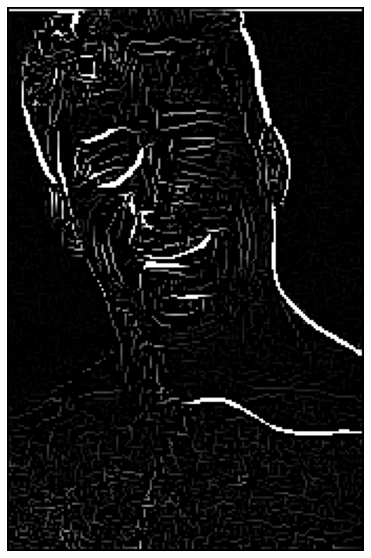

In [331]:
image_fi = non_max_suppression(image_fi_new, theta_fi)
draw(image_fi, 1)

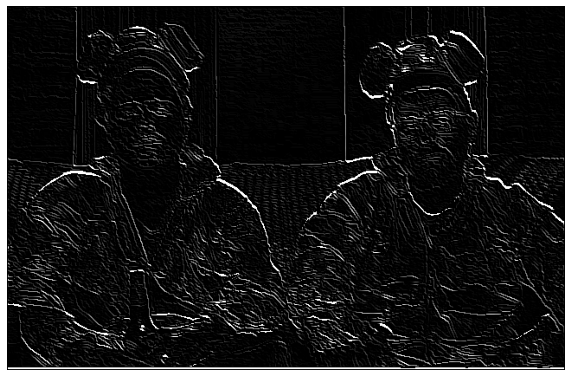

In [332]:
image_se = non_max_suppression(image_se_new, theta_se)
draw(image_se, 1)

#### Двойная пороговая фильтрация

Применение порога, чтобы определить находится или нет граница в данной точке изображения.
Выделение границ Канни использует два порога фильтрации:
1. Если значение пикселя выше верхней границы – он принимает максимальное значение
2. Если ниже – пиксель подавляется
3. Точки со значением, попадающим в диапазон между порогов, принимают фиксированное среднее значение (в данном случае 127)

In [342]:
def threshold(img: numpy.ndarray, lower_bound: int, upper_bound: int, middle: int = 127) -> numpy.ndarray:
    height, width = img.shape
    new_img = np.zeros((height, width,))
    for i in range(height):
        for j in range(width):
            if img[i][j] > upper_bound:
                new_img[i][j] = 255
            elif img[i][j] < lower_bound:
                new_img[i][j] = 0
            else:
                new_img[i][j] = middle
    return new_img

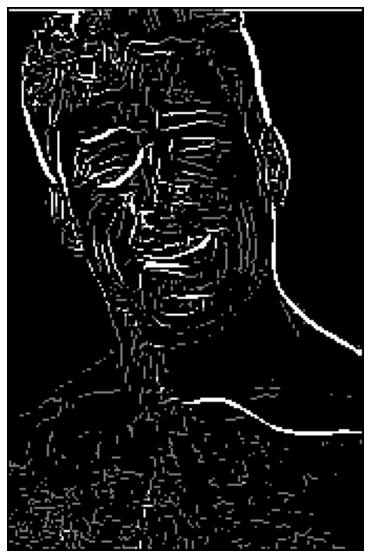

In [343]:
image_fi_new = threshold(image_fi, 40, 120)
draw(image_fi_new, 1)

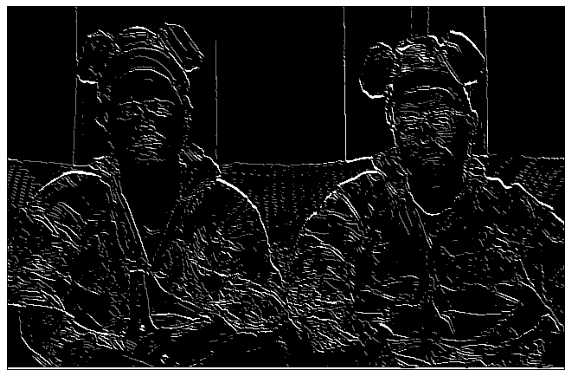

In [344]:
image_se_new = threshold(image_se, 50, 120)
draw(image_se_new, 1)

#### Трассировка области неоднозначности 

Задача сводится к выделению групп пикселей, получивших на предыдущем этапе промежуточное значение, и отнесению их:
1. К границе (если они соединены с одной из установленных границ) 
2. К подавлению (в противном случае). 

Пиксель добавляется к группе, если он соприкасается с ней по одному из 8-ми направлений (Все пиксели вокруг него).

In [346]:
def tracing(img: numpy.ndarray, middle: int = 127) -> numpy.ndarray:
    height, width = img.shape
    new_img = img.copy()
    direction = np.array([[-1, -1], [-1, 0], [-1, 1], [0, -1], [0, 1], [1, -1], [1, 0], [1, 1]])
    cnt = 0
    for i in range(1, height - 1):
         for j in range(1, width - 1):
                if (new_img[i][j] == middle):
                    for indx in range(8):
                        if (img[i + direction[indx][0]][j + direction[indx][1]] == 255):
                            new_img[i][j] = 255
                            break
                    new_img[i][j] = 0
    return new_img                

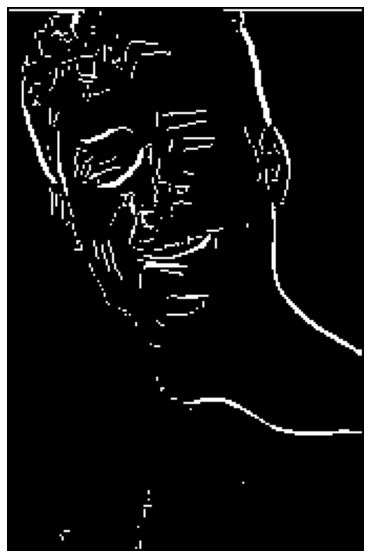

In [347]:
image_fi = tracing(image_fi_new)
draw(image_fi, 1)

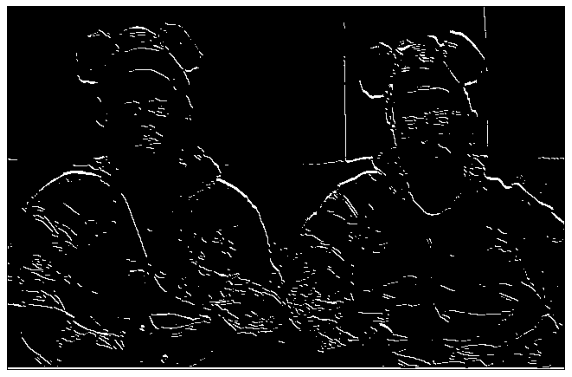

In [348]:
image_se = tracing(image_se_new)
draw(image_se, 1)

## Реализация с помощью opencv

In [365]:
cv_fi = cv2.imread("images/billy.jpg")
cv_fi = cv2.cvtColor(cv_fi, cv2.COLOR_BGR2RGB)

cv_se = cv2.imread("images/bb.jpg")
cv_se = cv2.cvtColor(cv_se, cv2.COLOR_BGR2RGB)

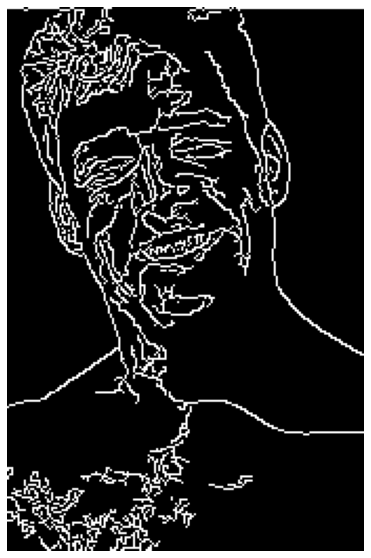

In [366]:
cv_canny = cv2.Canny(cv_fi, 75, 255)
draw(cv_canny, 1)

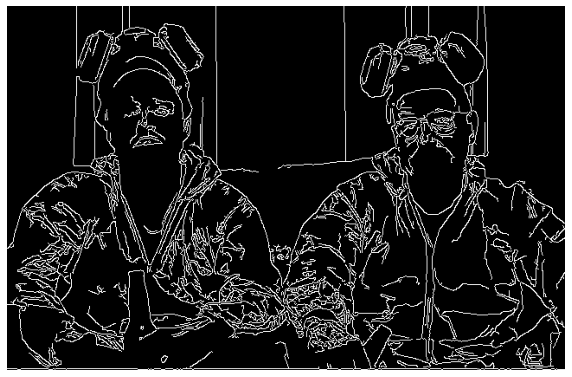

In [367]:
cv_canny_se = cv2.Canny(cv_se, 75, 255)
draw(cv_canny_se, 1)